In [1]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
import matplotlib.pyplot as plt

In [2]:
%config IPCompleter.use_jedi = False

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [3]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv  10_groups.csv  11_groups.csv  product_groups.csv


In [4]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [5]:
#g = pd.concat([g_9, g_10])
g = g_9

In [6]:
bad_ids = pd.read_csv('bad_ids.csv')
bad_ids = bad_ids['id_card'].values
clean = g[g['id_card'].isin(bad_ids)]
del g_9
#del g_10
del g

In [7]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


### I use only one month, because 2 are two large :((

## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

We are interested in probability $P(is\_discount>0 | sum)$.$H_0$ in this case is the uniform distribution of $P$, and the alternative hypothesis $H_a$ is $P(is\_discount>0 | sum)$ increases with respect to the sum.  $P(is\_discount>0 | sum) = \frac{P(sum | is\_discount>0) * P(is\_discount)}{P(sum)}\sim\frac{P(sum | is\_discount>0)}{P(sum)}$. I will make kolmogorov smirnov one-tailed test.

In [8]:
sums = clean.groupby(by='id_doc')[['sum', 'is_green']].sum()

In [9]:
discount_sums = sums[sums['is_green'] > 0]['sum'].values
sums = sums['sum'].values

<BarContainer object of 139 artists>

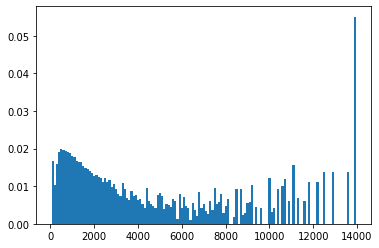

In [10]:
import numpy as np
hist_all, bin_edges = np.histogram(sums, np.arange(min(sums), 14000, 100))
hist_disc, _ = np.histogram(discount_sums, np.arange(min(sums), 14000, 100))
probs = [disc/_all if _all > 0 else 0 for disc, _all in zip(hist_disc, hist_all)]
probs = np.array(probs)
probs = probs / probs.sum()
plt.bar(bin_edges[1:], probs, width=100)

In [32]:
# we see that it is not uniform. However let's make kstest

In [11]:
probs_generated = np.random.choice(np.arange(0, len(probs)), 100000, p=probs)
uniform = np.random.uniform(0, len(probs), 100000).astype(int)


In [12]:
probs_generated = np.random.choice(np.arange(0, len(probs)), 100000, p=probs)/len(probs)

In [13]:
from scipy import stats
import numpy as np

print(f"Less: {stats.kstest(probs_generated, uniform, alternative='less')}")
print(f"Two-side: {stats.kstest(probs_generated, uniform, alternative='two-sided')}")
print(f"Greater: {stats.kstest(probs_generated, uniform, alternative='greater')}")


Less: KstestResult(statistic=0.0, pvalue=1.0)
Two-side: KstestResult(statistic=0.99291, pvalue=0.0)
Greater: KstestResult(statistic=0.99291, pvalue=0.0)


$H_0$ was rejected. We can conclude that buying discounted products depends on the average order sum. 

## Task 2
Prove that the frequency of shopping grows around the wage taking days. 

In [14]:
clean['day'] = pd.to_datetime(clean['date']).dt.date

In [15]:
freqs = clean[['day', 'id_doc']].groupby(['day']).nunique()

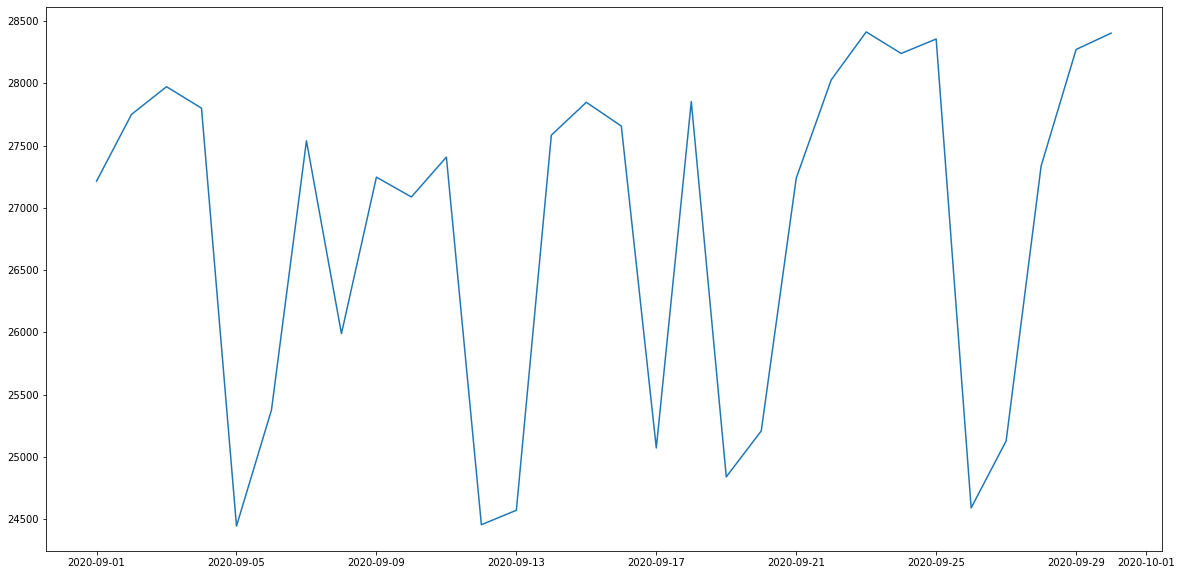

In [16]:
plt.figure(figsize=(20,10))
plt.plot(freqs)

we can see that 05 and 19 are local minimas after which frequency increases.1-4 - high frequencies.

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

Text(0, 0.5, 'Number of buyers')

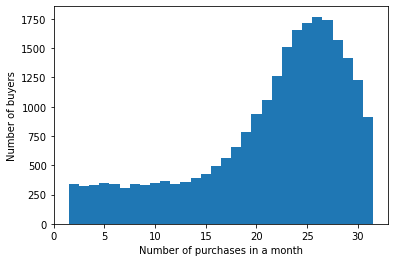

In [57]:
# 1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
frequency = clean.groupby(by='id_card')['day'].nunique()
freqs = frequency.values
hist, bin_edges = np.histogram(freqs, np.arange(1, 32))
plt.bar(bin_edges[1:], hist, width=1)
plt.xlabel('Number of purchases in a month')
plt.ylabel('Number of buyers')

In [29]:
np.unique(freqs, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([ 339,  323,  327,  345,  340,  308,  338,  329,  352,  369,  341,
         357,  388,  422,  490,  561,  657,  785,  934, 1053, 1265, 1507,
        1656, 1714, 1768, 1736, 1570, 1417, 1231,  909]))

In [30]:
#2. Average purchase sum - The customers that usually spend the same amount of money 
avg_sum = clean.groupby(by=['id_card', 'id_doc']).sum()
avg_sum

id_order  id_tov  id_kontr  quantity      sum  is_green  \
id_card id_doc                                                              
19      170926         0.0  117780     68034     5.000  1149.00         0   
        701539         0.0  305378    205997    26.265  2160.83         0   
        811410         0.0   51129     30486     2.000   332.40         2   
        1185914        0.0   16652     16612     1.000   118.80         1   
        1319294        0.0  388989    276910    27.287  2755.91         0   
...                    ...     ...       ...       ...      ...       ...   
1941912 20137534       0.0   28716     18705     2.000   223.00         0   
        20189694       0.0   35684     26912     2.000   162.00         0   
        20432977       0.0   41206     49351     1.448    72.27         1   
        21450745       0.0   90200     54510     3.000   430.00         0   
        22625485       0.0   51595     32621     3.000   253.00         0   

                  id_group  
id_card id_doc              
19      170926       50295  
        701539      151283  
        811410       20032  
        1185914      10069  
        1319294     191187  
...                    ...  
1941912 20137534     20482  
        20189694     20065  
        20432977     30176  
        21450745     10196  
        22625485     20132  

[804914 rows x 7 columns]

In [39]:
means = avg_sum['sum'].reset_index().groupby('id_card')['sum'].mean()

In [40]:
means = stds.dropna()

Text(0, 0.5, 'number of buyers')

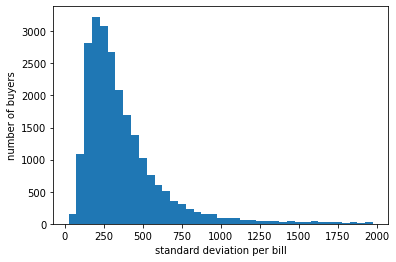

In [43]:
hist, bin_edges = np.histogram(means.values, np.arange(min(means.values), 2000, 50))
plt.bar(bin_edges[1:], hist, width=50)
plt.xlabel('standard deviation per bill')
plt.ylabel('number of buyers')

In [45]:
#3. Orders amount - The customers grouped by the total numer of orders 
counts = clean.groupby(by='id_card')['id_doc'].count()

Text(0, 0.5, 'number of buyers')

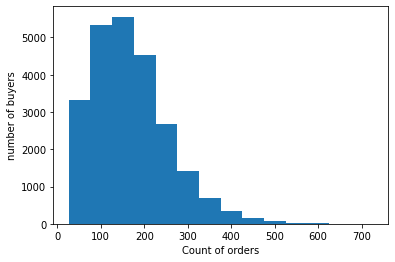

In [49]:
hist, bin_edges = np.histogram(counts.values, np.arange(min(counts.values), 750, 50))
plt.bar(bin_edges[1:], hist, width=50)
plt.xlabel('Count of orders')
plt.ylabel('number of buyers')

In [51]:
# 4. Usual cart - The customers grouped by the product groups
by_group = clean.groupby(by='id_group')['id_card']

In [56]:
#all buying "Кисломолочные продукты"
by_group.get_group(10004).values

array([ 563138,  526601,  676090, ..., 1213737, 1213737,  251068])